In [7]:
import os
import pandas as pd
import nibabel as nib
import numpy as np
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path

# ================= CONFIGURATION =================
# Chemins
root_dir = Path("archive/ISLES-2022/ISLES-2022/")
derivatives_dir = root_dir / "derivatives"

# Placeholder pour le CSV CHU (comme demandé)
csv_path = "train_chu.csv"

# Sorties
output_img_dir = "IMAGE_3D_FULL" # J'ai changé le nom pour ne pas mélanger
output_mask_dir = "MASKS_3D_FULL"
output_stats_dir = "./preprocessing_stats_3D_full"

os.makedirs(output_img_dir, exist_ok=True)
os.makedirs(output_mask_dir, exist_ok=True)
os.makedirs(output_stats_dir, exist_ok=True)

# --- NOUVEAUX PARAMÈTRES ---
RESIZE_TO = (224, 224)

# Seuil pour dire "Il y a un cerveau sur cette image"
# Une image 224x224 fait 50,176 pixels. 
# 1000 pixels (env 2%) est un bon seuil pour éviter les images vides/bruitées
MIN_BRAIN_PIXELS = 1000 


In [8]:
# ================= FONCTIONS UTILES =================
def robust_normalize(img):
    """Normalisation robuste avec clip des outliers."""
    img = np.nan_to_num(img, nan=0.0, posinf=0.0, neginf=0.0)
    p1, p99 = np.percentile(img, [1, 99])
    img_clipped = np.clip(img, p1, p99)
    if p99 - p1 > 1e-8:
        normalized = ((img_clipped - p1) / (p99 - p1) * 255).astype(np.uint8)
    else:
        normalized = np.zeros_like(img, dtype=np.uint8)
    return normalized

def create_rgb_image(dwi_slice, adc_slice):
    """Crée une image RGB (R=DWI, G=ADC, B=DWI)"""
    dwi_norm = robust_normalize(dwi_slice)
    adc_norm = robust_normalize(adc_slice)
    return np.stack([dwi_norm, adc_norm, dwi_norm], axis=-1)

def process_and_save_slice(dwi_slice, adc_slice, gt_slice, patient_id, plane_name, slice_idx):
    """Vérifie, traite et sauvegarde une slice"""
    
    # 1. Vérification "Est-ce qu'il y a un cerveau ?"
    # On regarde si l'image brute contient de l'information (valeur > un petit epsilon)
    # Les IRM ont souvent un fond parfaitement noir (0) ou très proche de 0
    brain_mask = dwi_slice > 1e-2 # Seuil très bas pour capter le tissu
    brain_pixels = np.count_nonzero(brain_mask)
    
    if brain_pixels < MIN_BRAIN_PIXELS:
        return False, "Pas assez de cerveau"

    # 2. Vérification "Image valide" (pas juste du bruit gris uniforme)
    if np.std(dwi_slice) < 1e-3: 
        return False, "Image plate/bruitée"

    # 3. Création image et masque
    # Note: On NE FILTRE PLUS sur la présence de lésion dans gt_slice !
    
    rgb = create_rgb_image(dwi_slice, adc_slice)
    rgb_resized = cv2.resize(rgb, RESIZE_TO, interpolation=cv2.INTER_LINEAR)
    
    mask = (gt_slice > 0).astype(np.uint8) * 255
    mask_resized = cv2.resize(mask, RESIZE_TO, interpolation=cv2.INTER_NEAREST)

    # 4. Sauvegarde
    filename = f"{patient_id}_{plane_name}_{slice_idx:03d}.png"
    
    cv2.imwrite(os.path.join(output_img_dir, filename), rgb_resized)
    cv2.imwrite(os.path.join(output_mask_dir, filename), mask_resized)
    
    return True, "OK"


In [9]:
# ================= PRÉPARATION DES DONNÉES =================
data_list = []

# Mode ISLES
if root_dir.exists() and derivatives_dir.exists():
    print("🔍 Mode ISLES détecté")
    subjects = sorted([d for d in root_dir.iterdir() if d.is_dir() and d.name.startswith("sub-strokecase")])
    
    for subj_path in tqdm(subjects, desc="Indexation"):
        subj_name = subj_path.name
        sessions = [s for s in subj_path.iterdir() if s.is_dir() and s.name.startswith("ses-")]
        
        for ses_path in sessions:
            ses_name = ses_path.name
            dwi_folder = ses_path / "dwi"
            if not dwi_folder.exists(): continue
            
            raw_files = list(dwi_folder.rglob("*.nii")) + list(dwi_folder.rglob("*.nii.gz"))
            dwi_file, adc_file = None, None
            for f in raw_files:
                if "dwi" in f.name.lower() and "adc" not in f.name.lower() and not f.name.startswith('.'): dwi_file = f
                elif "adc" in f.name.lower() and not f.name.startswith('.'): adc_file = f
            
            mask_search_path = derivatives_dir / subj_name / ses_name
            mask_file = None
            if mask_search_path.exists():
                candidates = list(mask_search_path.rglob("*.nii")) + list(mask_search_path.rglob("*.nii.gz"))
                candidates = [f for f in candidates if not f.name.startswith('.')]
                if candidates: mask_file = candidates[0]

            if dwi_file and adc_file and mask_file:
                data_list.append({
                    'sub_id': subj_name, 
                    'dwi_col': str(dwi_file), 
                    'adc_col': str(adc_file), 
                    'gt_col': str(mask_file)
                })

# Mode CHU (Conservation du code existant)
elif os.path.exists(csv_path):
    print("🔍 Mode CHU détecté (CSV)")
    df_chu = pd.read_csv(csv_path)
    # Logique CHU conservée...
    pass 

🔍 Mode ISLES détecté


Indexation: 100%|███████████████████████████| 250/250 [00:00<00:00, 3136.17it/s]


In [10]:
# ================= BOUCLE DE TRAITEMENT =================
stats = {
    'patients': 0,
    'total_generated': 0,
    'positive_samples': 0, # Avec lésion
    'negative_samples': 0, # Sans lésion (mais avec cerveau)
    'errors': []
}

print(f"\n🚀 Démarrage du traitement complet (Avec & Sans Lésions)...")

for item in tqdm(data_list, desc="Traitement 3D"):
    try:
        dwi_img = nib.load(item['dwi_col'])
        adc_img = nib.load(item['adc_col'])
        gt_img = nib.load(item['gt_col'])
        
        # Orientation canonique
        dwi_data = nib.as_closest_canonical(dwi_img).get_fdata()
        adc_data = nib.as_closest_canonical(adc_img).get_fdata()
        gt_data = nib.as_closest_canonical(gt_img).get_fdata()
        
        if not (dwi_data.shape == adc_data.shape == gt_data.shape):
            continue
            
        pat_id = item.get('sub_id', 'unknown')
        stats['patients'] += 1
        
        # Liste des plans à traiter
        planes = [
            ('axial', dwi_data, adc_data, gt_data), # Pas de rotation nécessaire sur Z en général
            ('coronal', dwi_data.transpose(0, 2, 1), adc_data.transpose(0, 2, 1), gt_data.transpose(0, 2, 1)),
            ('sagittal', dwi_data.transpose(1, 2, 0), adc_data.transpose(1, 2, 0), gt_data.transpose(1, 2, 0))
        ]
        
        for p_name, d_vol, a_vol, g_vol in planes:
            # On parcourt la dernière dimension (qui est devenue la "profondeur" après transpose)
            for i in range(d_vol.shape[2]):
                # Extraction 2D
                d_slice = np.rot90(d_vol[:, :, i])
                a_slice = np.rot90(a_vol[:, :, i])
                g_slice = np.rot90(g_vol[:, :, i])
                
                success, msg = process_and_save_slice(d_slice, a_slice, g_slice, pat_id, p_name, i)
                
                if success:
                    stats['total_generated'] += 1
                    if np.sum(g_slice) > 0:
                        stats['positive_samples'] += 1
                    else:
                        stats['negative_samples'] += 1

    except Exception as e:
        stats['errors'].append(f"Erreur {item.get('sub_id')}: {e}")


🚀 Démarrage du traitement complet (Avec & Sans Lésions)...


Traitement 3D: 100%|██████████████████████████| 250/250 [01:57<00:00,  2.13it/s]



📊 RAPPORT FINAL
Total Images     : 44616
  - Avec Lésion  : 17810 (39.9%)
  - Sans Lésion  : 26806 (60.1%)
------------------

Exemple d'image SANS lésion (Background sain): sub-strokecase0193_sagittal_147.png


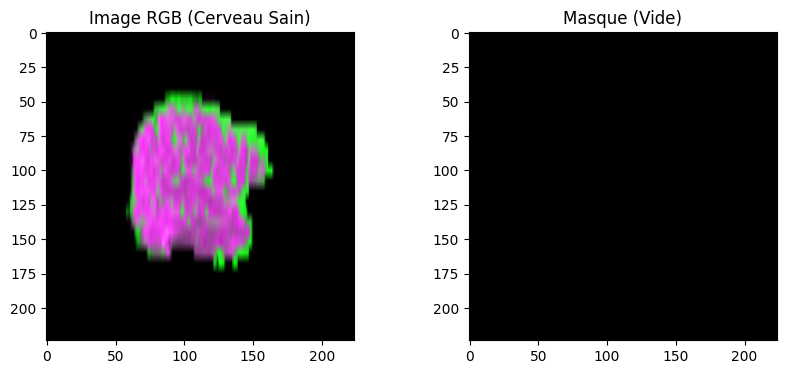

In [11]:
# ================= RAPPORT =================
print("\n" + "="*30)
print("📊 RAPPORT FINAL")
print("="*30)
print(f"Total Images     : {stats['total_generated']}")
print(f"  - Avec Lésion  : {stats['positive_samples']} ({stats['positive_samples']/stats['total_generated']*100:.1f}%)")
print(f"  - Sans Lésion  : {stats['negative_samples']} ({stats['negative_samples']/stats['total_generated']*100:.1f}%)")
print(f"------------------")

# Vérification visuelle d'un exemple "Sans Lésion"
import random
saved_files = os.listdir(output_img_dir)
if saved_files:
    # On cherche un masque vide pour l'exemple
    empty_mask_examples = []
    for f in saved_files[:100]: # On check les 100 premiers pour aller vite
        msk_test = cv2.imread(os.path.join(output_mask_dir, f), cv2.IMREAD_GRAYSCALE)
        if np.sum(msk_test) == 0:
            empty_mask_examples.append(f)
            
    if empty_mask_examples:
        example = random.choice(empty_mask_examples)
        print(f"\nExemple d'image SANS lésion (Background sain): {example}")
        img = cv2.imread(os.path.join(output_img_dir, example))
        msk = cv2.imread(os.path.join(output_mask_dir, example))
        
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1); plt.imshow(img); plt.title("Image RGB (Cerveau Sain)")
        plt.subplot(1, 2, 2); plt.imshow(msk, cmap='gray'); plt.title("Masque (Vide)")
        plt.show()